**For mounting drive**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from keras import layers, models
from keras.preprocessing.image import ImageDataGenerator, load_img
from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
import zipfile
import os
import re

Libraries

In [ ]:
DATASET_ZIP = 'drive/MyDrive/raw_vowels_3K_images.zip'
IMAGE_SHAPE = (120, 120, 1)

In [ ]:
with zipfile.ZipFile(DATASET_ZIP, 'r') as z:
  z.extractall('data')
#os.rename('data/shuffled', 'data/train')


In [ ]:
TRAIN_PATH = 'data/shuffled'
print('Number of images in the dataset: ', len(os.listdir(TRAIN_PATH)))


Number of images in the dataset:  3000


In [ ]:
files = os.listdir(TRAIN_PATH)
target = []
for filename in os.listdir(TRAIN_PATH):
  substr = re.search('_(.+?)t', filename)
  if(substr):
    category = substr.group(1)
    target.append(category)

# Create a DataFrame
df = pd.DataFrame({
    'filename': files,
    'category': target
})

In [ ]:
print('Number of unique characters: {}'.format(df['category'].unique()))
df.head()


Number of unique characters: ['007' '003' '006' '004' '005' '001' '009' '000' '002' '008' '010' '155']


,filename,category
0,u28_007t06.tiff,007
1,u31_007t07.tiff,007
2,u18_003t03.tiff,003
3,u22_006t01.tiff,006
4,u47_004t01.tiff,004


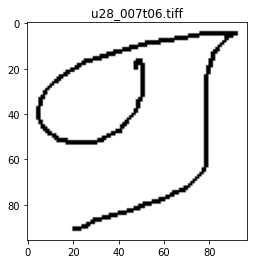

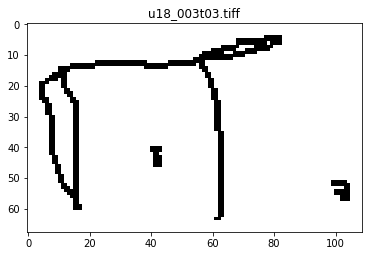

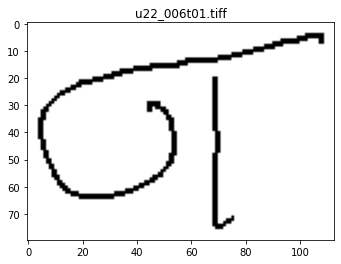

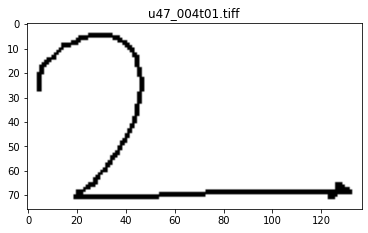

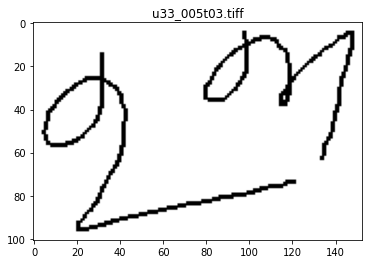

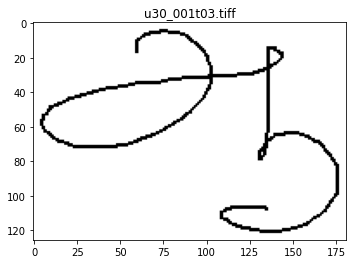

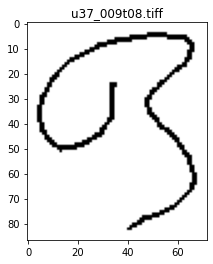

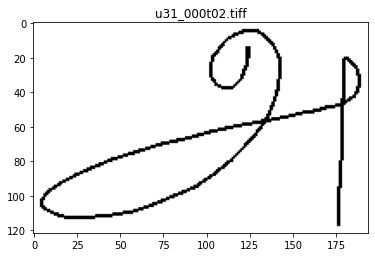

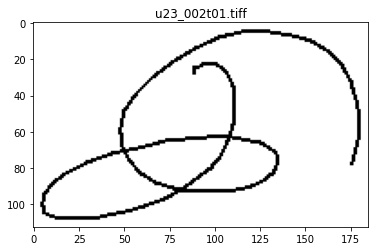

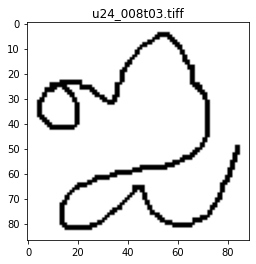

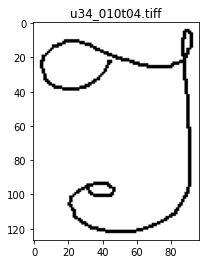

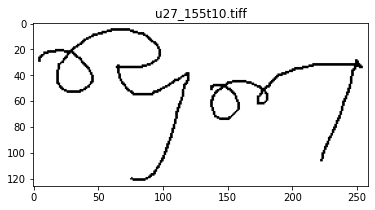

In [ ]:
for each in df['category'].unique():
  filename = df[df['category'] == each]['filename'].iloc[0]
  plt.figure()
  img = mpimg.imread(os.path.join(TRAIN_PATH, filename))
  plt.imshow(img)
  plt.title(filename)
  plt.show()

In [ ]:
MAP = {
    '000':u'\u0B85', 
    '001':u'\u0B86', 
    '002':u'\u0B87', 
    '003':u'\u0B88', 
    '004':u'\u0B89', 
    '005':u'\u0B8A', 
    '006':u'\u0B8E', 
    '007':u'\u0B8F', 
    '008':u'\u0B90', 
    '009':u'\u0B92', 
    '010':u'\u0B93', 
    '155':u'\u0B94'
    }
MAP.items()    

dict_items([('000', 'அ'), ('001', 'ஆ'), ('002', 'இ'), ('003', 'ஈ'), ('004', 'உ'), ('005', 'ஊ'), ('006', 'எ'), ('007', 'ஏ'), ('008', 'ஐ'), ('009', 'ஒ'), ('010', 'ஓ'), ('155', 'ஔ')])

In [ ]:
df.drop(df[df['category'] == '155'].index, inplace = True) 

In [ ]:
df['category'].value_counts()

004    276
000    276
002    276
007    275
005    275
001    274
003    272
009    271
008    269
010    268
006    267
Name: category, dtype: int64

In [ ]:
height, width, depth = [], [], []
for filename in df['filename']:
  img = mpimg.imread(os.path.join(TRAIN_PATH, filename))
  h, w, d = img.shape
  height.append(h)
  width.append(w)
  depth.append(d)

dim_df = pd.DataFrame({
    'height': height,
    'width': width,
    'depth': depth
})

In [ ]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=28) 
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

Train Dataset Size:  2399
Validation Dataset Size:  600


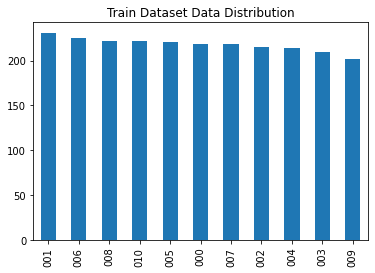

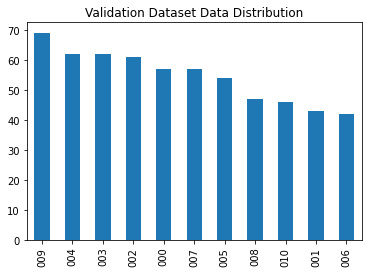

In [ ]:
print('Train Dataset Size: ', len(train_df))
print('Validation Dataset Size: ', len(val_df))


train_df['category'].value_counts().plot.bar()
plt.title('Train Dataset Data Distribution')
plt.show()

plt.figure()

val_df['category'].value_counts().plot.bar()
plt.title('Validation Dataset Data Distribution')
plt.show()

In [ ]:
batch_size = 120
epoch = 50

train_count = train_df.shape[0]
val_count = val_df.shape[0]

train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 10,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    horizontal_flip=False,
    fill_mode='nearest', 
    )

train_gen = train_datagen.flow_from_dataframe(
    train_df,
    directory = TRAIN_PATH,
    x_col = 'filename',
    y_col = 'category',
    class_mode = 'categorical',
    target_size = IMAGE_SHAPE[:2],
    batch_size = batch_size,
    color_mode='grayscale'
)

val_gen = train_datagen.flow_from_dataframe(
    val_df,
    directory = TRAIN_PATH,
    x_col = 'filename',
    y_col = 'category',
    class_mode = 'categorical',
    target_size = IMAGE_SHAPE[:2],
    batch_size = batch_size,
    color_mode='grayscale'
) 

Found 2399 validated image filenames belonging to 11 classes.
Found 600 validated image filenames belonging to 11 classes.


In [ ]:
def build_model():
  model = models.Sequential()

  model.add(layers.Conv2D(32, (5, 5), activation='relu', input_shape=IMAGE_SHAPE))
  model.add(layers.MaxPool2D(pool_size=(2, 2)))
  model.add(layers.Dropout(0.2))

  model.add(layers.Conv2D(32, (5, 5), activation='relu'))
  model.add(layers.MaxPool2D(pool_size=(2, 2)))
  model.add(layers.Dropout(0.2))
  
  model.add(layers.Flatten())
  model.add(layers.Dense(256, activation='relu'))
  model.add(layers.Dense(11, activation='softmax'))

  model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
  return model

model = build_model()

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 116, 116, 32)      832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 58, 58, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 58, 58, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 54, 54, 32)        25632     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 27, 27, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 27, 27, 32)        0

In [ ]:
history = model.fit(
    train_gen,
    epochs=epoch,
    steps_per_epoch = train_count // batch_size,
    validation_data = val_gen,
    validation_steps = val_count // batch_size,
    #callbacks = callbacks
)

Epoch 1/50
19/19 [==============================] - 16s 291ms/step - loss: 3.1879 - accuracy: 0.1132 - val_loss: 2.3734 - val_accuracy: 0.2250
Epoch 2/50
19/19 [==============================] - 5s 265ms/step - loss: 2.1944 - accuracy: 0.2374 - val_loss: 2.0202 - val_accuracy: 0.3967
Epoch 3/50
19/19 [==============================] - 5s 257ms/step - loss: 1.8028 - accuracy: 0.3831 - val_loss: 1.6409 - val_accuracy: 0.4600
Epoch 4/50
19/19 [==============================] - 5s 255ms/step - loss: 1.5553 - accuracy: 0.4840 - val_loss: 1.4996 - val_accuracy: 0.5067
Epoch 5/50
19/19 [==============================] - 5s 258ms/step - loss: 1.3158 - accuracy: 0.5480 - val_loss: 1.2639 - val_accuracy: 0.6183
Epoch 6/50
19/19 [==============================] - 5s 257ms/step - loss: 1.1204 - accuracy: 0.6200 - val_loss: 1.0794 - val_accuracy: 0.5950
Epoch 7/50
19/19 [==============================] - 5s 260ms/step - loss: 0.9810 - accuracy: 0.6661 - val_loss: 0.8249 - val_accuracy: 0.7167
Epoch

In [ ]:
model.save("tamil_handwritten_char.h5")

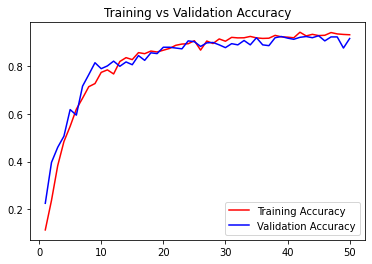

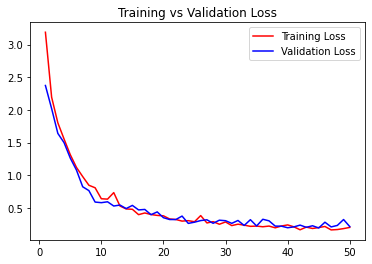

In [ ]:
epoch_xaxis = range(1, len(history.history['accuracy'])+1)

plt.plot(epoch_xaxis, history.history['accuracy'], 'r', label='Training Accuracy')
plt.plot(epoch_xaxis, history.history['val_accuracy'], 'b', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.show()

plt.figure()

plt.plot(epoch_xaxis, history.history['loss'], 'r', label='Training Loss')
plt.plot(epoch_xaxis, history.history['val_loss'], 'b', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()